https://www.tensorflow.org/tfmodels/vision/object_detection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

2025-09-11 14:26:32.150424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757593592.484211   44689 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757593592.576706   44689 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757593593.367147   44689 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757593593.367168   44689 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757593593.367170   44689 computation_placer.cc:177] computation placer alr

In [3]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

/home/frederic.boisnard/virtualenvs/tf-retinanet-env2/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


2.19.0


In [4]:
# Au début de votre notebook, après les imports
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Désactive complètement le GPU

# Ou alternativement, forcer TensorFlow à utiliser le CPU
tf.config.set_visible_devices([], 'GPU')

2025-09-11 14:26:52.057148: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-09-11 14:26:52.057180: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-09-11 14:26:52.057184: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-09-11 14:26:52.057186: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-09-11 14:26:52.057188: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: deel05.irtse-pf.ext
2025-09-11 14:26:52.057190: I external/local_xla/xla/stream_executo

# Keras_cv

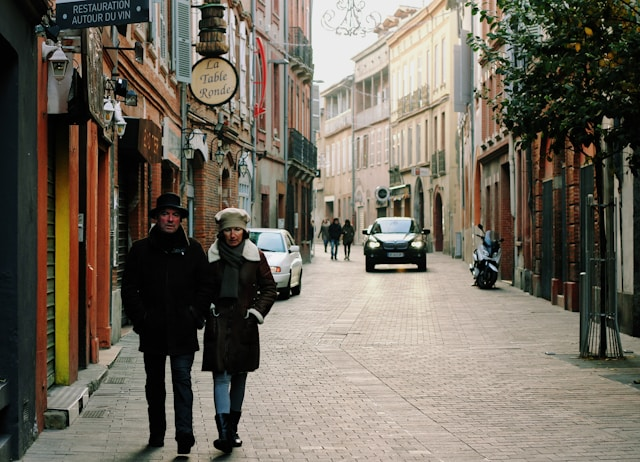

In [5]:
raw_image = Image.open("img.jpg")
raw_image

In [6]:
def resize_image(image, target_height=640):
    width, height = image.size
    target_width = int(width * target_height / height)
    return image.resize((target_width, target_height), Image.Resampling.LANCZOS)

resized_image = resize_image(raw_image)
print(resized_image.size)  # Affiche la nouvelle taille de l'image

(886, 640)


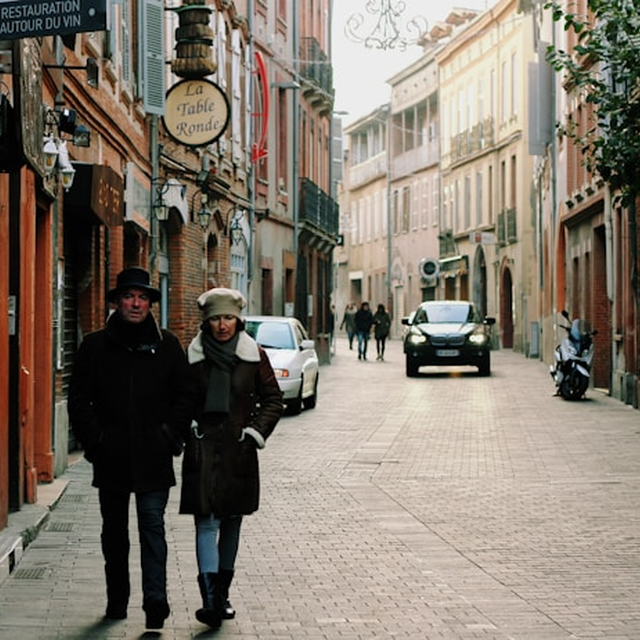

In [7]:
# crop to 640x640
image = resized_image.crop((100, 0, 740, 640))
image

# Load & test the model on the image

In [8]:
import tensorflow as tf
import numpy as np
from PIL import Image
from keras_cv.models import RetinaNet

print(RetinaNet.presets.keys())
model = RetinaNet.from_preset("retinanet_resnet50_pascalvoc")

# Retinanet needs a 640x640 image
img_np = np.array(image, dtype=np.float32)

# Prétraitement
input_tensor = tf.expand_dims(img_np, axis=0)

# Inference
processed_results = model.predict(input_tensor)
print(f"keys in the processed results: {processed_results.keys()}")

/home/frederic.boisnard/virtualenvs/tf-retinanet-env2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dict_keys(['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnet18_v2', 'resnet34_v2', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2', 'mobilenet_v3_small', 'mobilenet_v3_large', 'csp_darknet_tiny', 'csp_darknet_s', 'csp_darknet_m', 'csp_darknet_l', 'csp_darknet_xl', 'efficientnetv1_b0', 'efficientnetv1_b1', 'efficientnetv1_b2', 'efficientnetv1_b3', 'efficientnetv1_b4', 'efficientnetv1_b5', 'efficientnetv1_b6', 'efficientnetv1_b7', 'efficientnetv2_s', 'efficientnetv2_m', 'efficientnetv2_l', 'efficientnetv2_b0', 'efficientnetv2_b1', 'efficientnetv2_b2', 'efficientnetv2_b3', 'densenet121', 'densenet169', 'densenet201', 'efficientnetlite_b0', 'efficientnetlite_b1', 'efficientnetlite_b2', 'efficientnetlite_b3', 'efficientnetlite_b4', 'yolo_v8_xs_backbone', 'yolo_v8_s_backbone', 'yolo_v8_m_backbone', 'yolo_v8_l_backbone', 'yolo_v8_xl_backbone', 'vitdet_base', 'vitdet_large', 'vitdet_huge', 'videoswin_tiny', 'videoswin_small', 'videoswin_base', 'resnet50_imagenet', 'resnet50_v

/home/frederic.boisnard/virtualenvs/tf-retinanet-env2/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
keys in the processed results: dict_keys(['boxes', 'confidence', 'classes', 'num_detections'])


In [9]:
model.predict(input_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


{'boxes': array([[[397.792   , 303.65884 ,  95.95203 ,  77.749146],
         [ 70.721275, 269.9328  , 122.03614 , 362.35358 ],
         [246.41211 , 322.6927  ,  73.30243 ,  94.083496],
         [370.7401  , 303.15918 ,  20.050049,  59.251404],
         [175.08127 , 303.01733 , 116.54611 , 327.3214  ],
         [544.6745  , 328.55637 ,  52.86035 ,  77.80408 ],
         [346.3427  , 303.01358 ,  22.486633,  58.82251 ],
         [192.6492  , 309.28625 , 131.01569 , 101.636475],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  

In [13]:
# from xplique.utils_functions.object_detection import test_model_gradients
from xplique.utils_functions.object_detection.tf.gradients_check import check_model_gradients

print("Testing gradients on model.predict")
check_model_gradients(model.predict, input_tensor)

Testing gradients on model.predict

--- Testing Eager mode ---


/home/frederic.boisnard/virtualenvs/tf-retinanet-env2/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/frederic.boisnard/virtualenvs/tf-retinanet-env2/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step
boxes: KO No gradients
confidence: KO No gradients
classes: KO No gradients
num_detections: KO No gradients

--- Testing Graph mode ---


/home/frederic.boisnard/virtualenvs/tf-retinanet-env2/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(None, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Graph mode failed completely: in user code:

    File "/home/frederic.boisnard/virtualenvs/tf-retinanet-env2/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 509, in error_handler  *
        filtered_tb = _process_traceback_frames(e.__traceback__)
    File "/home/frederic.boisnard/virtualenvs/tf-retinanet-env2/lib/python3.12/site-packages/optree/ops.py", line 766, in tree_map
        return treespec.unflatten(map(func, *flat_args))

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


=== SUMMARY ===
Eager mode: FAIL
Graph mode: FAIL


False

# Cut model in 2 -> LatentExtractor

### Make an adapter for the model to check its behavior

In [15]:
# PASCAL classes
CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
           'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
           'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
nb_classes = len(CLASSES)
print(nb_classes)
from xplique.concepts.latent_extractor import LatentExtractor
from xplique.utils_functions.object_detection.tf.box_formatter import  TfXpliqueBoxFormatter
from xplique.utils_functions.object_detection.common.box_manager import BoxFormat, BoxType

20


In [16]:
class RetinaNetProcessedBoxFormatter(TfXpliqueBoxFormatter):

    def __init__(self, nb_classes: int,
                 input_box_type: BoxType = BoxType(BoxFormat.XYWH, is_normalized=False),
                 output_box_type: BoxType = BoxType(BoxFormat.XYXY, is_normalized=True),
                 input_image_size: tuple = None,
                 output_image_size: tuple = None,
                 **kwargs):
        super().__init__(input_box_type, output_box_type)
        
        self.nb_classes = nb_classes
        self.input_image_size = input_image_size
        self.output_image_size = output_image_size

    # eager mode forward method
    def forward_eager(self, predictions):
        results = []
        for boxes, scores, classes in zip(predictions['boxes'], predictions['confidence'], predictions['classes']):
            labels_one_hot = tf.one_hot(tf.cast(classes, tf.int32), depth=self.nb_classes)
            # swap coordinates from (ymin, xmin, ymax, xmax) to (xmin, ymin, xmax, ymax)
            # boxes = tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)
            scores = scores[:, tf.newaxis]
            pred_dict = {
                'boxes': boxes,
                'scores': scores,
                'probas': labels_one_hot
            }
            formatted = self.format_predictions(pred_dict, self.input_image_size, self.output_image_size)
            results.append(formatted)
        result = tf.stack(results, axis=0)
        return result

    # graph mode forward pass
    def forward(self, predictions):
        def process_single_batch(batch_idx):
            boxes = predictions['boxes'][batch_idx]
            scores = predictions['confidence'][batch_idx] 
            classes = predictions['classes'][batch_idx]
            
            labels_one_hot = tf.one_hot(tf.cast(classes, tf.int32), depth=self.nb_classes)
            scores_expanded = scores[:, tf.newaxis]
            
            pred_dict = {
                'boxes': boxes,
                'scores': scores_expanded,
                'probas': labels_one_hot
            }
            return self.format_predictions(pred_dict, self.input_image_size, self.output_image_size)

        batch_size = tf.shape(predictions['boxes'])[0]
        batch_indices = tf.range(batch_size)
        
        results = tf.map_fn(
            process_single_batch,
            batch_indices,
            fn_output_signature=tf.TensorSpec(shape=(None, 4 + 1 + self.nb_classes), dtype=tf.float32),
            parallel_iterations=1
        )
        
        return results

processed_formatter = RetinaNetProcessedBoxFormatter(nb_classes=nb_classes, input_image_size=(640, 640), output_image_size=(640, 640))

### LatentData class

In [17]:
from xplique.concepts.latent_data_retinanet import TfLatentDataRetinanet

In [18]:
import types

from keras_cv.src.backend import ops
from keras_cv.src import bounding_box
from keras_cv.src.bounding_box.converters import _decode_deltas_to_boxes

def g(self, samples) -> TfLatentDataRetinanet:
    backbone_outputs = self.feature_extractor(samples, training=False)
    return TfLatentDataRetinanet(backbone_outputs, tuple(samples[0].shape))

def h(self, latent_data: TfLatentDataRetinanet):
    backbone_outputs, image_shape = latent_data.resnet_features, latent_data.image_shape
    features = self.feature_pyramid(backbone_outputs, training=False)
    cls_outputs = []
    box_outputs = []
    for feature in features:
        cls_outputs.append(self.classification_head(feature))
        box_outputs.append(self.box_head(feature))
    
    # 4. Concatener les sorties
    cls_outputs = tf.concat([tf.reshape(c, [tf.shape(c)[0], -1, self.num_classes]) for c in cls_outputs], axis=1)
    box_outputs = tf.concat([tf.reshape(b, [tf.shape(b)[0], -1, 4]) for b in box_outputs], axis=1)
    
    # 5. Si training=False, appliquer le post-processing
    # if not training:
    def decode_predictions_reworked(predictions, image_shape):
        BOX_VARIANCE = [0.1, 0.1, 0.2, 0.2]
        box_pred, cls_pred = predictions["box"], predictions["classification"]
        # box_pred is on "center_yxhw" format, convert to target format.
        # image_shape = tuple(images[0].shape)
        anchors = model.anchor_generator(image_shape=image_shape)
        anchors = ops.concatenate([a for a in anchors.values()], axis=0)

        box_pred = _decode_deltas_to_boxes(
            anchors=anchors,
            boxes_delta=box_pred,
            anchor_format=model.anchor_generator.bounding_box_format,
            box_format=model.bounding_box_format,
            variance=BOX_VARIANCE,
            image_shape=image_shape,
        )
        # box_pred is now in "self.bounding_box_format" format
        box_pred = bounding_box.convert_format(
            box_pred,
            source=model.bounding_box_format,
            target=model.prediction_decoder.bounding_box_format,
            image_shape=image_shape,
        )

        #### fonction a remplacer: model.prediction_decoder()
        # (self, box_prediction, class_prediction, images=None, image_shape=None)
        box_prediction = box_pred
        class_prediction = cls_pred

        # Logits to probas
        predictions = ops.sigmoid(class_prediction)
        # predicted_class = ops.argmax(predictions, axis=-1)
        # Take the class with the highest confidence
        confidence = ops.max(predictions, axis=-1)
        classes = ops.argmax(predictions, axis=-1)

        bounding_boxes = {
            "boxes": box_prediction,
            "scores": predictions,
            "confidence": confidence,
            "classes": classes,
        }
        return bounding_boxes
    
    return decode_predictions_reworked(
        {"classification": cls_outputs, "box": box_outputs}, 
        image_shape
    )

# model.decode_predictions_reworked = types.MethodType(decode_predictions_reworked, model)
model.h = types.MethodType(h, model)
model.g = types.MethodType(g, model)

### Use LatentExtractor model to test the whole pipeline

Number of kept annotations: 27
cl:6, Drawing box for car with color g at coords (399.0928955078125, 303.27392578125, 494.22198486328125, 382.52288818359375) with score 0.95
cl:6, Drawing box for car with color g at coords (398.7728576660156, 301.60394287109375, 494.4248046875, 382.1993408203125) with score 0.91
cl:6, Drawing box for car with color g at coords (398.84124755859375, 305.7301025390625, 492.73126220703125, 384.0069885253906) with score 0.94
cl:6, Drawing box for car with color g at coords (400.3656005859375, 302.8454895019531, 494.809326171875, 380.5221862792969) with score 0.92
cl:6, Drawing box for car with color g at coords (400.1158447265625, 301.8968505859375, 493.05029296875, 380.9490966796875) with score 0.86
cl:6, Drawing box for car with color g at coords (400.69110107421875, 304.5480041503906, 493.7721252441406, 381.8966369628906) with score 0.93
cl:6, Drawing box for car with color g at coords (397.6895751953125, 302.4598083496094, 490.8375549316406, 380.88088989

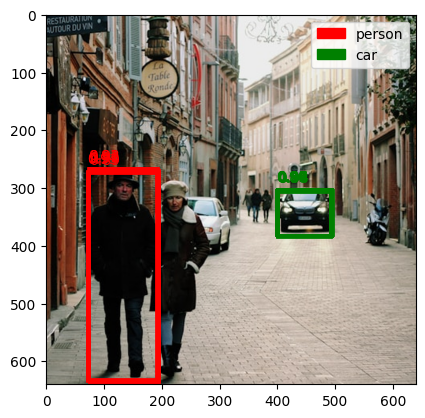

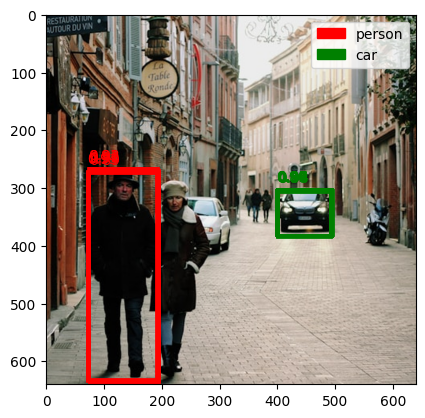

In [20]:
from xplique.concepts.latent_extractor import LatentExtractor, TfLatentExtractor

latent_extractor = TfLatentExtractor(model, model.g, model.h, latent_data_class=TfLatentDataRetinanet, output_formatter=processed_formatter, batch_size=1)
results = latent_extractor(input_tensor)

from xplique.plots.display_image_with_boxes import display_image_with_boxes_tf
label_to_color = {'person': 'r',
                  'bicycle': 'b',
                  'car': 'g',
                  'motorcycle': 'y',
                  'truck': 'orange'}
display_image_with_boxes_tf(image, results[0], BoxFormat.XYXY, True, CLASSES, label_to_color, accuracy=0.85)

Number of kept annotations: 27
cl:6, Drawing box for car with color g at coords (399.0928955078125, 303.27392578125, 494.22198486328125, 382.52288818359375) with score 0.95
cl:6, Drawing box for car with color g at coords (398.7728576660156, 301.60394287109375, 494.4248046875, 382.1993408203125) with score 0.91
cl:6, Drawing box for car with color g at coords (398.84124755859375, 305.7301025390625, 492.73126220703125, 384.0069885253906) with score 0.94
cl:6, Drawing box for car with color g at coords (400.3656005859375, 302.8454895019531, 494.809326171875, 380.5221862792969) with score 0.92
cl:6, Drawing box for car with color g at coords (400.1158447265625, 301.8968505859375, 493.05029296875, 380.9490966796875) with score 0.86
cl:6, Drawing box for car with color g at coords (400.69110107421875, 304.5480041503906, 493.7721252441406, 381.8966369628906) with score 0.93
cl:6, Drawing box for car with color g at coords (397.6895751953125, 302.4598083496094, 490.8375549316406, 380.88088989

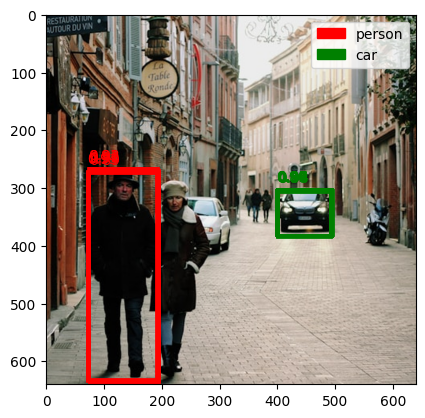

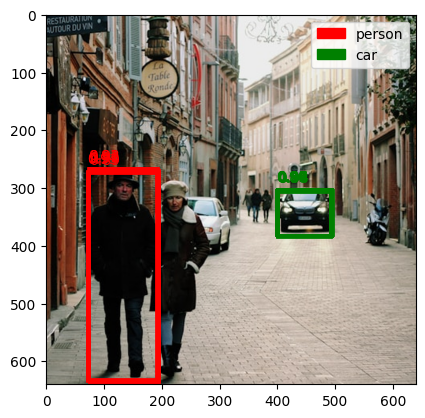

In [21]:
display_image_with_boxes_tf(image, results[0], BoxFormat.XYXY, True, CLASSES, label_to_color, accuracy=0.85)

In [22]:
print("Testing gradients on latent extractor")
check_model_gradients(latent_extractor, input_tensor)

Testing gradients on latent extractor

--- Testing Eager mode ---
Tensor: OK - (1, 640, 640, 3)

--- Testing Graph mode ---
Tensor: OK - (1, 640, 640, 3)

=== SUMMARY ===
Eager mode: OK
Graph mode: OK


True

## Test builder

In [23]:
from xplique.concepts.latent_data_retinanet import buildTfRetinaNetLatentExtractor

latent_extractor2 = buildTfRetinaNetLatentExtractor(model, nb_classes)

In [25]:
check_model_gradients(latent_extractor2, input_tensor)


--- Testing Eager mode ---
Tensor: OK - (1, 640, 640, 3)

--- Testing Graph mode ---


Tensor: OK - (1, 640, 640, 3)

=== SUMMARY ===
Eager mode: OK
Graph mode: OK


True

### Test saliency

In [26]:
import xplique
from xplique.attributions import Saliency
from xplique.commons.operators import object_detection_operator

In [27]:
targets = latent_extractor(input_tensor)
print(targets.shape)

(1, 76725, 25)


In [29]:
from xplique.utils_functions.object_detection.tf.box_manager import filter_boxes as filter_boxes_tf
filtered_targets = filter_boxes_tf(targets, accuracy=0.9, class_id=CLASSES.index('car'))
box_to_explain = np.array(filtered_targets)
print(len(box_to_explain[0]))

18


In [30]:
# Simple operator test
operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
scores = operator(latent_extractor, input_tensor, box_to_explain)
print(scores)

tf.Tensor([0.95008534], shape=(1,), dtype=float32)


In [31]:
operator=xplique.Tasks.OBJECT_DETECTION
explainer = Saliency(latent_extractor, operator=operator, batch_size=None)
explanation = explainer.explain(input_tensor, targets=box_to_explain)

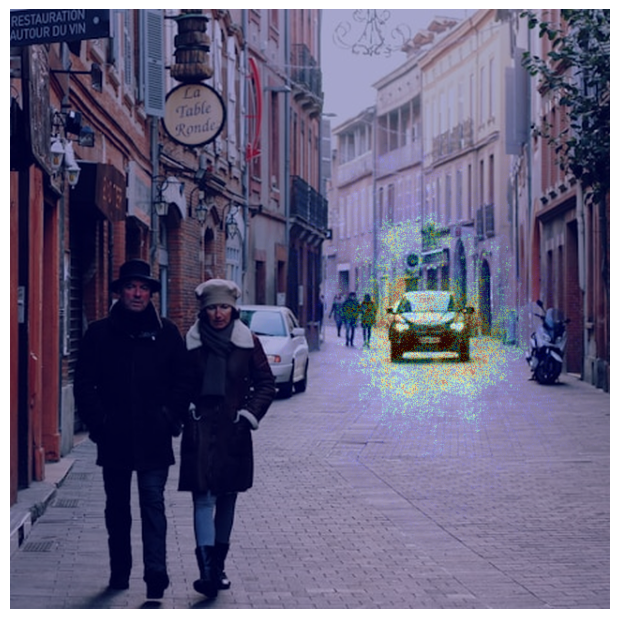

In [32]:
from xplique.plots import plot_attributions
plot_attributions(explanation, [np.array(image)], img_size=6.,
                  cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

# Craft

Number of kept annotations: 27
cl:6, Drawing box for car with color g at coords (399.0928955078125, 303.27392578125, 494.22198486328125, 382.52288818359375) with score 0.95
cl:6, Drawing box for car with color g at coords (398.7728576660156, 301.60394287109375, 494.4248046875, 382.1993408203125) with score 0.91
cl:6, Drawing box for car with color g at coords (398.84124755859375, 305.7301025390625, 492.73126220703125, 384.0069885253906) with score 0.94
cl:6, Drawing box for car with color g at coords (400.3656005859375, 302.8454895019531, 494.809326171875, 380.5221862792969) with score 0.92
cl:6, Drawing box for car with color g at coords (400.1158447265625, 301.8968505859375, 493.05029296875, 380.9490966796875) with score 0.86
cl:6, Drawing box for car with color g at coords (400.69110107421875, 304.5480041503906, 493.7721252441406, 381.8966369628906) with score 0.93
cl:6, Drawing box for car with color g at coords (397.6895751953125, 302.4598083496094, 490.8375549316406, 380.88088989

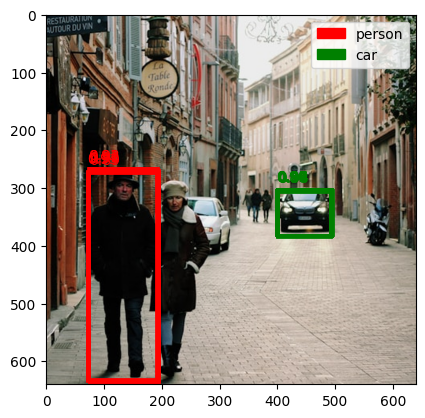

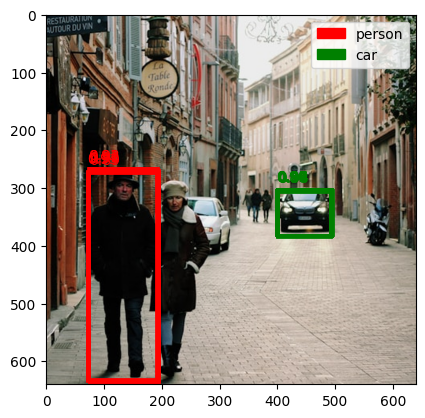

In [33]:
results = latent_extractor(input_tensor)
display_image_with_boxes_tf(image, results[0], BoxFormat.XYXY, True, CLASSES, label_to_color, accuracy=0.85)

## Craft avec fit generique

In [34]:
# test_latent_fpn = TfLatentDataRetinanet(fpn_features = (
#         tf.zeros((1, 80, 80, 256)),
#         tf.zeros((1, 40, 40, 256)),
#         tf.zeros((1, 20, 20, 256)),
#         tf.zeros((1, 10, 10, 256)),
#         tf.zeros((1, 5, 5, 256))
#     ),
#     image_shape = (640, 640))

# test_latent_fpn2 = TfLatentDataRetinanet(fpn_features = (
#         tf.zeros((2, 80, 80, 256)),
#         tf.zeros((2, 40, 40, 256)),
#         tf.zeros((2, 20, 20, 256)),
#         tf.zeros((2, 10, 10, 256)),
#         tf.zeros((2, 5, 5, 256))
#     ),
#     image_shape = (640, 640))

# test_latent_fpn3 = TfLatentDataRetinanet.aggregate(test_latent_fpn, test_latent_fpn2)

# test_latent_fpn3 = test_latent_fpn.aggregate(test_latent_fpn2)
# test_latent_fpn3.print_infos()

In [35]:
latent_data = latent_extractor.input_to_latent(input_tensor)
#(input_tensor)

In [36]:
latent_data.get_activations().shape

TensorShape([1, 20, 20, 2048])

In [37]:
type(latent_data.resnet_features)
latent_data.resnet_features.keys()

dict_keys(['P3', 'P4', 'P5'])

In [38]:
latent_data.print_infos()

LatentDataRetinanet:
	Feature P3: shape (1, 80, 80, 512)
	Feature P4: shape (1, 40, 40, 1024)
	Feature P5: shape (1, 20, 20, 2048)
Image shape: (640, 640, 3)


In [39]:
from xplique.concepts.latent_data_retinanet import TfLatentDataRetinanet

# create a test test latent data for Retinanet with resnet features that is a dictionary of:
# Feature P3: shape (1, 80, 80, 512)
# 	Feature P4: shape (1, 40, 40, 1024)
# 	Feature P5: shape (1, 20, 20, 2048)
test_latent_retinanet = TfLatentDataRetinanet(resnet_features = {
    "P3": tf.zeros((1, 80, 80, 512)),
    "P4": tf.zeros((1, 40, 40, 1024)),
    "P5": tf.zeros((1, 20, 20, 2048))
    },
    image_shape = (640, 640))
test_latent_retinanet.print_infos()

test_latent_retinanet2 = TfLatentDataRetinanet(resnet_features = {
        "P3": tf.zeros((2, 80, 80, 512)),
        "P4": tf.zeros((2, 40, 40, 1024)),
        "P5": tf.zeros((2, 20, 20, 2048))
    },
    image_shape = (640, 640))
test_latent_retinanet2.print_infos()

test_latent_retinanet3 = TfLatentDataRetinanet.aggregate(test_latent_retinanet, test_latent_retinanet2)
test_latent_retinanet3.print_infos()

test_latent_retinanet3 = test_latent_retinanet.aggregate(test_latent_retinanet2)
test_latent_retinanet3.print_infos()

test_latent_retinanet3 = TfLatentDataRetinanet.aggregate(test_latent_retinanet)
test_latent_retinanet3.print_infos()

LatentDataRetinanet:
	Feature P3: shape (1, 80, 80, 512)
	Feature P4: shape (1, 40, 40, 1024)
	Feature P5: shape (1, 20, 20, 2048)
Image shape: (640, 640)
LatentDataRetinanet:
	Feature P3: shape (2, 80, 80, 512)
	Feature P4: shape (2, 40, 40, 1024)
	Feature P5: shape (2, 20, 20, 2048)
Image shape: (640, 640)
[latent_data_retinanet] Aggregating LatentDataRetinanet... with 1 additional instances.
LatentDataRetinanet:
	Feature P3: shape (3, 80, 80, 512)
	Feature P4: shape (3, 40, 40, 1024)
	Feature P5: shape (3, 20, 20, 2048)
Image shape: (640, 640)
[latent_data_retinanet] Aggregating LatentDataRetinanet... with 1 additional instances.
LatentDataRetinanet:
	Feature P3: shape (3, 80, 80, 512)
	Feature P4: shape (3, 40, 40, 1024)
	Feature P5: shape (3, 20, 20, 2048)
Image shape: (640, 640)
[latent_data_retinanet] Aggregating LatentDataRetinanet... with 0 additional instances.
LatentDataRetinanet:
	Feature P3: shape (1, 80, 80, 512)
	Feature P4: shape (1, 40, 40, 1024)
	Feature P5: shape (1,

In [41]:
from xplique.concepts.holistic_craft_object_detection_tf import HolisticCraftObjectDetectionTf as Craft
craft = Craft(latent_extractor = latent_extractor,
              number_of_concepts = 10)
_, activations, coeffs_u, concept_bank_w = craft.fit(input_tensor)

Total batches: 1, Batch size: 1, Dataset size: 1
[TfLatentExtractor] Calling input_to_latent_model(batch)...
[TfLatentExtractor] Number of latent data batches: 1
activations shape before NMF: (1, 20, 20, 2048)
coeffs_u shape after NMF.fit_transform(): (400, 10)
coeffs_u rearranged shape: (1, 20, 20, 10)


In [42]:
input_tensor.shape

TensorShape([1, 640, 640, 3])

Total batches: 1, Batch size: 1, Dataset size: 1
[TfLatentExtractor] Calling input_to_latent_model(batch)...
[TfLatentExtractor] Number of latent data batches: 1
[HolisticCraftObjectDetectionTf] activations_flat shape: (400, 2048) from original activations shape: (1, 20, 20, 2048)
[HolisticCraftObjectDetectionTf] final coeffs_u shape: (1, 20, 20, 10) from original activations shape: (1, 20, 20),  -1


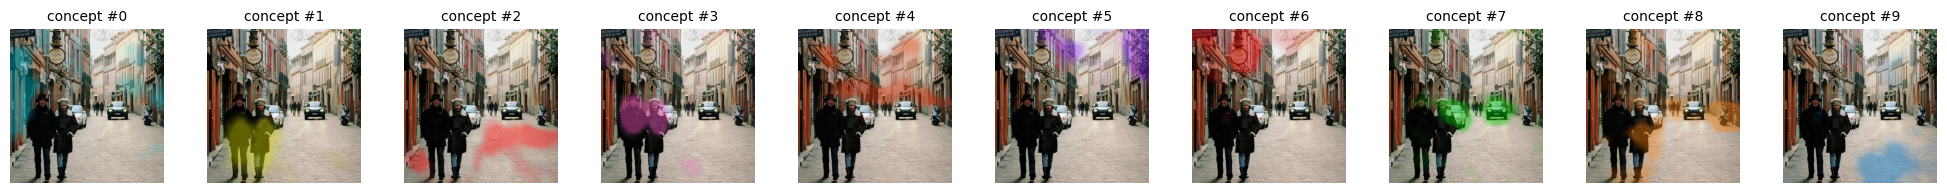

In [43]:
fig = craft.display_images_per_concept(input_tensor, order=None, filter_percentile=80, clip_percentile=5)

In [44]:
type(coeffs_u)

numpy.ndarray

Total batches: 1, Batch size: 1, Dataset size: 1
[TfLatentExtractor] Calling input_to_latent_model(batch)...
[TfLatentExtractor] Number of latent data batches: 1
[HolisticCraftObjectDetectionTf] activations_flat shape: (400, 2048) from original activations shape: (1, 20, 20, 2048)
[HolisticCraftObjectDetectionTf] final coeffs_u shape: (1, 20, 20, 10) from original activations shape: (1, 20, 20),  -1
(1, 20, 20, 10)
(1, 20, 20, 10)
(1, 76725, 25)
Number of kept annotations: 2
cl:6, Drawing box for car with color g at coords (399.46136474609375, 303.9136657714844, 491.02935791015625, 380.83868408203125) with score 0.93
cl:6, Drawing box for car with color g at coords (400.51324462890625, 302.03729248046875, 491.9620056152344, 380.7623291015625) with score 0.91


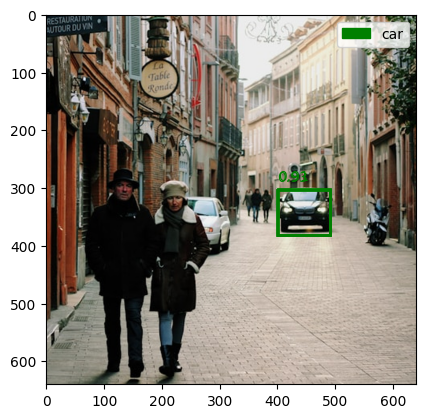

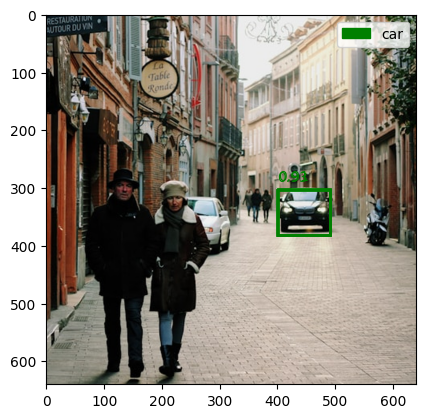

In [45]:
# test réencodage
# coeffs_u
latent_data, coeffs_u2 = craft.encode(input_tensor)
print(coeffs_u.shape)
print(coeffs_u2.shape)
result = craft.decode(latent_data, coeffs_u)
print(result.shape)
display_image_with_boxes_tf(image, result[0], BoxFormat.XYXY, True, CLASSES, label_to_color, accuracy=0.85)

# Debug GradientInput

In [49]:
# from xplique.utils_functions.box_manager import filter_boxes_tf, filter_boxes_same_dim_tf
from xplique.utils_functions.object_detection.tf.box_manager import filter_boxes_same_dim as filter_boxes_same_dim_tf
from xplique.attributions import GradientInput

In [50]:
# avec filter same dim -> bcp de resultats

class_id = CLASSES.index("person")
accuracy = 0.6
harmonize = False

latent_data, coeffs_u = craft.encode(input_tensor)
decoder = craft.make_decoder(latent_data)
# output = decoder(tf.convert_to_tensor(coeffs_u))
output = decoder(coeffs_u)

class_filtered_output = filter_boxes_same_dim_tf(output, class_id=class_id, accuracy=accuracy)
print(len(class_filtered_output))

np_arrays = [t.numpy() for t in class_filtered_output]
stacked_np = np.stack(np_arrays, axis=0)
print(stacked_np.shape)

Total batches: 1, Batch size: 1, Dataset size: 1
[TfLatentExtractor] Calling input_to_latent_model(batch)...
[TfLatentExtractor] Number of latent data batches: 1
[HolisticCraftObjectDetectionTf] activations_flat shape: (400, 2048) from original activations shape: (1, 20, 20, 2048)
[HolisticCraftObjectDetectionTf] final coeffs_u shape: (1, 20, 20, 10) from original activations shape: (1, 20, 20),  -1
[HolisticCraftObjectDetectionTf] decode_tf: coeffs_u.shape=(1, 20, 20, 10), concept_bank_w.shape=(10, 2048)
1
(1, 76725, 25)


In [51]:
# avec filter normal (bcp moins de resultats) mais en liste

class_id = CLASSES.index("person")
accuracy = 0.6
harmonize = False

latent_data, coeffs_u = craft.encode(input_tensor)
decoder = craft.make_decoder(latent_data)
# output = decoder(tf.convert_to_tensor(coeffs_u))
output = decoder(coeffs_u)

class_filtered_output = filter_boxes_tf(output, class_id=class_id, accuracy=accuracy)

# class_filtered_output = filter_boxes_same_dim_tf(output, class_id=class_id, accuracy=accuracy)
# print(len(class_filtered_output))

np_arrays = [t.numpy() for t in class_filtered_output]
stacked_np = np.stack(np_arrays, axis=0)
print(stacked_np.shape)

Total batches: 1, Batch size: 1, Dataset size: 1
[TfLatentExtractor] Calling input_to_latent_model(batch)...
[TfLatentExtractor] Number of latent data batches: 1
[HolisticCraftObjectDetectionTf] activations_flat shape: (400, 2048) from original activations shape: (1, 20, 20, 2048)
[HolisticCraftObjectDetectionTf] final coeffs_u shape: (1, 20, 20, 10) from original activations shape: (1, 20, 20),  -1
[HolisticCraftObjectDetectionTf] decode_tf: coeffs_u.shape=(1, 20, 20, 10), concept_bank_w.shape=(10, 2048)
(1, 6, 25)


In [52]:
np_arrays

[array([[0.5794532 , 0.47394785, 0.6101549 , 0.56424344, 0.6095794 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.57976675, 0.47184682, 0.61021996, 0.56499267, 0.68572646,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.5783571 , 0.47208634, 0.610628  , 0.5656263 , 0.63048947,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        ,

In [ ]:
# calling the temp model with coeffs_u.shape=(1, 20, 20, 10)

In [ ]:
# print(f"decoder.input: {decoder.input}")  # ← Ne devrait plus lever d'erreur
# print(f"decoder.output: {decoder.output}")  # ← Ne devrait plus lever d'erreur

In [53]:
explainer = GradientInput(decoder, operator=operator, harmonize=harmonize, batch_size=1)

In [54]:
stacked_np.shape

(1, 6, 25)

In [55]:
explanation = explainer.explain(inputs=coeffs_u, targets=stacked_np)

[HolisticCraftObjectDetectionTf] decode_tf: coeffs_u.shape=(1, 20, 20, 10), concept_bank_w.shape=(10, 2048)


2025-09-11 14:36:48.553187: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
explanation.shape

TensorShape([1, 20, 20, 10])

In [57]:
sum_per_image_and_concept = np.sum(explanation, axis=(1,2))
importances = np.mean(sum_per_image_and_concept, axis=0)
print(importances)

[ 0.0027639   0.18257333  0.00326822  0.22419418  0.03345694  0.00025418
 -0.00109499  0.04156652 -0.01271285  0.00065716]


In [58]:
# operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
# importances = craft.estimate_importance_gradient_input_xplique(input_tensor, operator, class_id=CLASSES.index("person"), accuracy=0.9)
# print(f"{importances.shape = }")

Total batches: 1, Batch size: 1, Dataset size: 1
[TfLatentExtractor] Calling input_to_latent_model(batch)...
[TfLatentExtractor] Number of latent data batches: 1
[HolisticCraftObjectDetectionTf] activations_flat shape: (400, 2048) from original activations shape: (1, 20, 20, 2048)
[HolisticCraftObjectDetectionTf] final coeffs_u shape: (1, 20, 20, 10) from original activations shape: (1, 20, 20),  -1


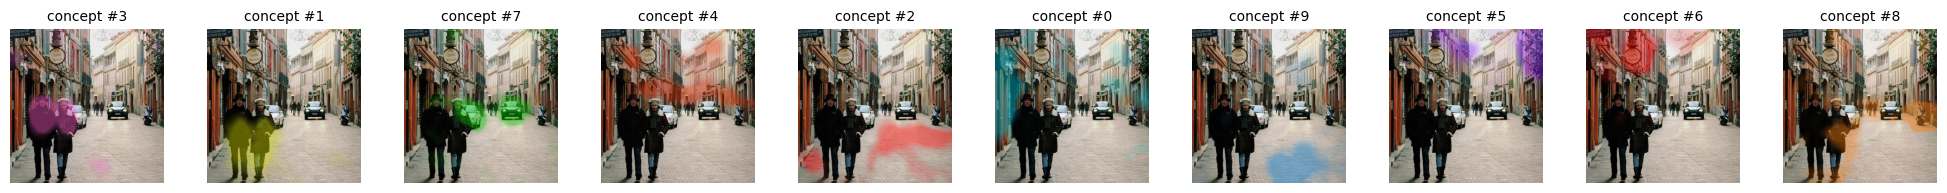

In [59]:
order = importances.argsort()[::-1]
fig = craft.display_images_per_concept(input_tensor, order=order, filter_percentile=80, clip_percentile=5)

# Gradient Input

[HolisticCraftObjectDetectionTf] compute_gradient_input: batch_size=1, images.shape=(1, 640, 640, 3), class_id=14, accuracy=0.6
[HolisticCraftObjectDetectionTf] processing batch 0 with shape (1, 640, 640, 3)
Total batches: 1, Batch size: 1, Dataset size: 1
[TfLatentExtractor] Calling input_to_latent_model(batch)...
[TfLatentExtractor] Number of latent data batches: 1
[HolisticCraftObjectDetectionTf] activations_flat shape: (400, 2048) from original activations shape: (1, 20, 20, 2048)
[HolisticCraftObjectDetectionTf] final coeffs_u shape: (1, 20, 20, 10) from original activations shape: (1, 20, 20),  -1
[HolisticCraftObjectDetectionTf] Calling the decoder with coeffs_u.shape=(1, 20, 20, 10)
[HolisticCraftObjectDetectionTf] decode_tf: coeffs_u.shape=(1, 20, 20, 10), concept_bank_w.shape=(10, 2048)
[HolisticCraftObjectDetectionTf] stacked_np shape: (1, 6, 25)
[HolisticCraftObjectDetectionTf] using the GradientInput explainer with operator=<tensorflow.python.eager.polymorphic_function.pol

2025-09-11 14:36:52.769536: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[HolisticCraftObjectDetectionTf] explanation_list length: 1
[HolisticCraftObjectDetectionTf] estimate_importance_gradient_input_xplique: explanation.shape=(1, 20, 20, 10)
Total batches: 1, Batch size: 1, Dataset size: 1
[TfLatentExtractor] Calling input_to_latent_model(batch)...
[TfLatentExtractor] Number of latent data batches: 1
[HolisticCraftObjectDetectionTf] activations_flat shape: (400, 2048) from original activations shape: (1, 20, 20, 2048)
[HolisticCraftObjectDetectionTf] final coeffs_u shape: (1, 20, 20, 10) from original activations shape: (1, 20, 20),  -1


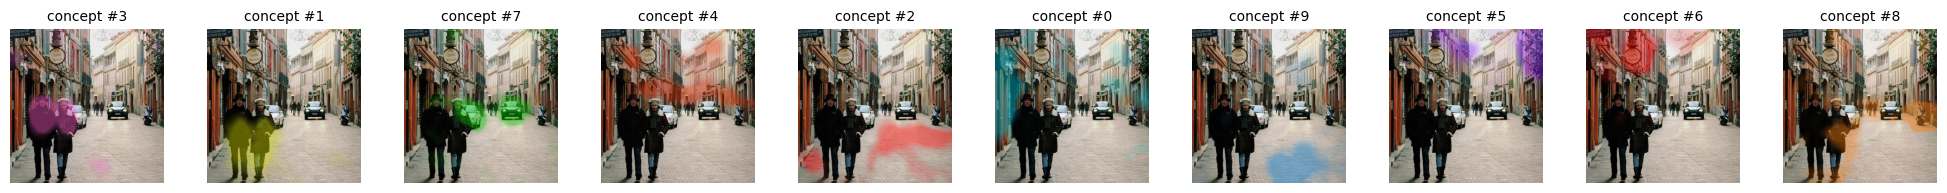

In [60]:
importances_gi = craft.estimate_importance_gradient_input_xplique(input_tensor, operator, class_id, accuracy=0.6, batch_size=1)

order = importances_gi.argsort()[::-1]
fig = craft.display_images_per_concept(input_tensor, order=order, filter_percentile=80, clip_percentile=5)